In [5]:
from lib.utils import load_nursing_by_index
import plotly.express as px
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset

X,y = load_nursing_by_index(2,dir='../data/nursing.chrisogonas/')
df = pd.DataFrame(X.numpy(),columns=['acc_x','acc_y','acc_z'])
df['y'] = y.long()
df = df[::5]
df = df.reset_index(drop=True)

In [6]:
fig = px.line(df,y=['acc_x','acc_y','acc_z','y'])
fig.show(renderer='browser')

In [337]:
def get_windowed_from_raw_dataframe(dataframe,window_size=101,labels=True):
    X = torch.from_numpy(df[['acc_x','acc_y','acc_z']].to_numpy())
    x = X[:,0].unsqueeze(1)
    xs = [x[:-(window_size-1)]]
    for i in range(1,window_size-1):
        xs.append(x[i:i-(window_size-1)])
    xs.append(x[(window_size-1):])
    X = torch.cat(xs,axis=1).float()
    if(labels):
        y = torch.from_numpy(df['y'].to_numpy())
        y = y[window_size//2:-(window_size//2)].unsqueeze(1).float()
        return X,y
    return X

In [338]:
X,y = get_windowed_from_raw_dataframe(df)
torch.save(X,'X.pt')
torch.save(y,'y.pt')

In [366]:
from torch.utils.data import Dataset
from torch import load
class Sequences(Dataset):
    def __init__(self,targets,labels):
        self.targets = targets
        self.labels = labels

    def __len__(self):
        return len(self.labels)-8

    def __getitem__(self, idx):
        X = self.targets[idx:idx+9]
        y = self.labels[idx+4]

        return (X,y)

In [367]:
len(Sequences(X,y))

28492

In [369]:
trainloader = DataLoader(Sequences(X,y),batch_size=32,shuffle=True)

In [370]:
X,y = next(iter(trainloader))

In [371]:
X.shape

torch.Size([32, 9, 101])

In [372]:
from torch import nn
from torch.nn.functional import relu
class MODEL(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=101,hidden_size=32,batch_first=True)
        self.fc1 = nn.Linear(in_features=288,out_features=1)
    def forward(self, x):
        o,(h,c) = self.lstm(x)
        x = self.fc1(o.reshape(-1,9*32))
        return x

In [373]:
device = 'cuda'
model = MODEL().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  17569


100%|██████████| 891/891 [00:00<00:00, 901.80it/s]


tensor(0.0162)


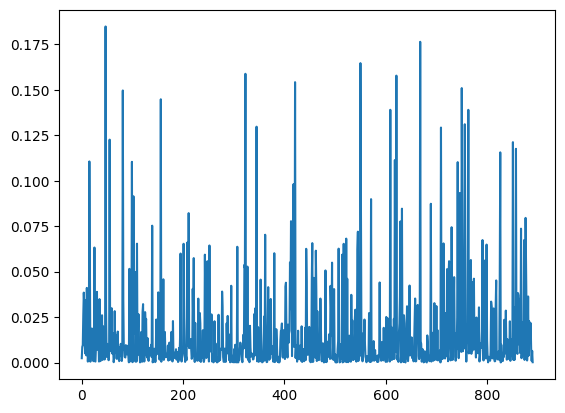

In [380]:
from tqdm import tqdm
lossi = []
model.train()

for i in range(1):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)
print(torch.tensor(lossi).mean())

100%|██████████| 891/891 [00:00<00:00, 2064.49it/s]


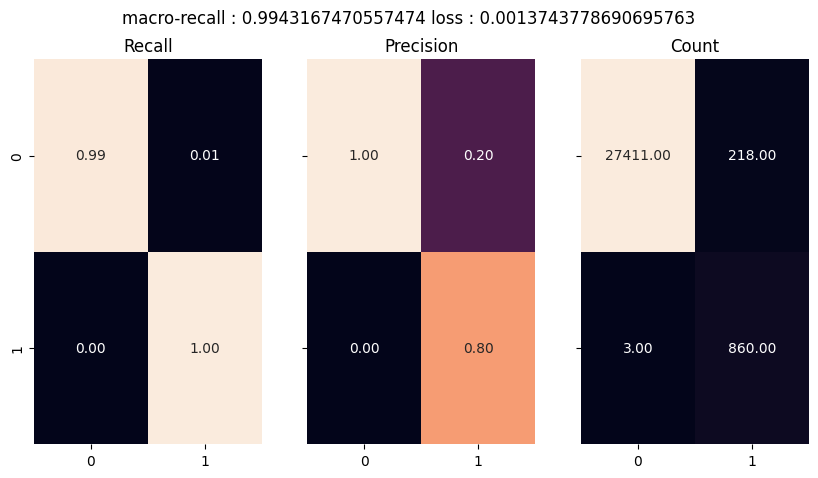

In [381]:
from lib.utils import test_evaluation
loss,y_true,y_pred = test_evaluation(trainloader,model,criterion)